# How to Segment Buildings on Drone Imagery with Fast.ai & Cloud-Native GeoData Tools

## An Interactive Intro to Geospatial Deep Learning on Google Colab 




# Inference on new imagery

With our segmentation model trained and exported for inference use, we will now re-load it as an inference-only model to test on new unseen imagery. We'll test the generalizability of our trained segmentation model on tiles from drone imagery captured over another part of Zanzibar and in other parts of the world as well as at varying `zoom_levels` (locations and zoom levels indicated):

![](https://cdn-images-1.medium.com/max/1200/1*DaS2dVfeaxZCg6cqOcHDrg.jpeg)

We'll also compare our model inference time per tile on GPU versus CPU.

## Load exported model for inference

In [100]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0    811      0 --:--:-- --:--:-- --:--:--   815
Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.callbacks import *

In [102]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.59
fastprogress  : 0.1.22
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Fri Dec 27 11:51:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+-------

In [0]:
# TODO: look into better way of loading export.pkl w/o needing to redefine these custom classes

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom
    
def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1) == target).float().mean()

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        ch_loss=0
        for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
            ch_loss+=loss_wt*loss_func(output[:,1,None], target[:,0,None])
        loss+=1*(ch_loss)
        return loss/sum(self.ch_wts)

# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels
def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,0,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,0,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)


In [104]:
# to mount and transfer to GDrive: uncomment and run this and the next cell, follow instructions to auhorize access to your GDrive
from google.colab import drive
drive.mount('/content/drive')
base_path="/content/drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
inference_learner = load_learner(path='/content/drive/My Drive/models/', file='rio0001trn-focaldice-unfrozen.pkl')

In [106]:
inference_learner.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: /content/drive/My Drive/models;

Valid: LabelList (0 items)
x: SegmentationItemList

y: SegmentationLabelList

Path: /content/drive/My Drive/models;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), s

## Inference on new unseen tiles


In [0]:
import skimage 
import time

def get_pred(learner, tile):
#     pdb.set_trace()
    t_img = Image(pil2tensor(tile[:,:,:3],np.float32).div_(255))
    outputs = learner.predict(t_img)
    im = image2np(outputs[2].sigmoid())[:, :, 1]
    im = (im*255).astype('uint8')
    return im

In [0]:
# try a different tile by changing or adding your own urls to list

urls = [
  'https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png',
  'https://tiles.openaerialmap.org/5b1e6fd42b6a08001185f7bf/0/5b1e6fd42b6a08001185f7c0/20/569034/537093.png',
  'https://tiles.openaerialmap.org/5beaaba463f9420005ef8db0/0/5beaaba463f9420005ef8db1/19/313479/283111.png',
  'https://tiles.openaerialmap.org/5d050c3673de290005853a91/0/5d050c3673de290005853a92/18/203079/117283.png',
  'https://tiles.openaerialmap.org/5c88ff77225fc20007ab4e26/0/5c88ff77225fc20007ab4e27/21/1035771/1013136.png',
  'https://tiles.openaerialmap.org/5d30bac2e757aa0005951652/0/5d30bac2e757aa0005951653/19/136700/197574.png'
]

### On GPU

### On CPU

In [0]:
threshold = 200

https://tiles.openaerialmap.org/5b1009f22b6a08001185f24a/0/5b1009f22b6a08001185f24b/19/319454/270706.png
CPU inference took 0.39 secs


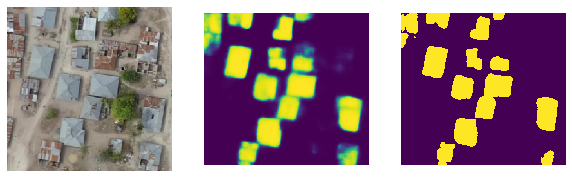

https://tiles.openaerialmap.org/5b1e6fd42b6a08001185f7bf/0/5b1e6fd42b6a08001185f7c0/20/569034/537093.png
CPU inference took 0.36 secs


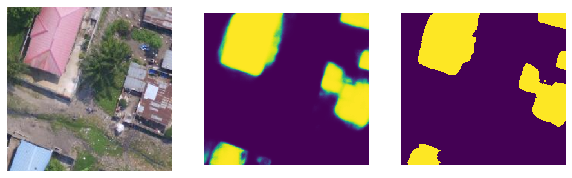

https://tiles.openaerialmap.org/5beaaba463f9420005ef8db0/0/5beaaba463f9420005ef8db1/19/313479/283111.png
CPU inference took 0.36 secs


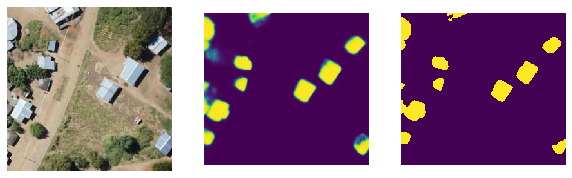

https://tiles.openaerialmap.org/5d050c3673de290005853a91/0/5d050c3673de290005853a92/18/203079/117283.png
CPU inference took 0.33 secs


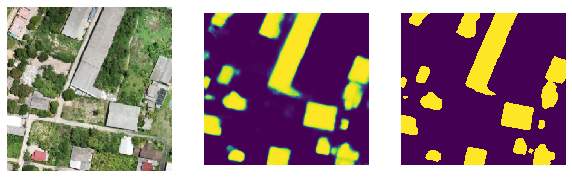

https://tiles.openaerialmap.org/5c88ff77225fc20007ab4e26/0/5c88ff77225fc20007ab4e27/21/1035771/1013136.png
CPU inference took 0.32 secs


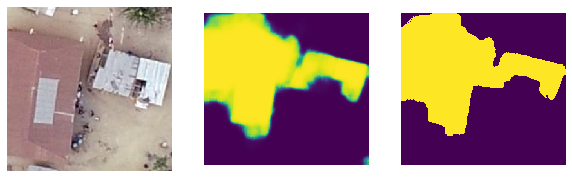

https://tiles.openaerialmap.org/5d30bac2e757aa0005951652/0/5d30bac2e757aa0005951653/19/136700/197574.png
CPU inference took 0.31 secs


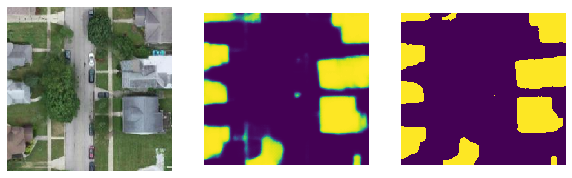

In [110]:
for url in urls:
  t1 = time.time()
  test_tile = skimage.io.imread(url)
  print(url)
  result = get_pred(inference_learner, test_tile)

  t2 = time.time()
  
  print(f'CPU inference took {t2-t1:.2f} secs')
  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
  ax1.imshow(test_tile)
  ax2.imshow(result)
  ax3.imshow((result > threshold).astype(float))
  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  plt.show()

# Post-processing

## Predict on a tile, threshold, polygonize, and georegister

Once the model is trained, and we have Istanbul (or some districts) map divided into 200x200m tiles, we perform 4 steps: ask for prediction to our fabulous model, threshold the output heatmap and 

Using solaris and geopandas, we'll convert our model's prediction as a 3-channel pixel raster output into a GeoJSON file by:

1. thresholding and combining the 3-channels of pixel values in our raw prediction output into a 1 channel binary pixel mask
2. polygonizing this binary pixel mask into shape vectors representing the predicted footprint of every building
3. georegistering the x, y display coordinates of these vectorized building shapes into longitude, latitude coordinates

## Predict on a tile, threshold and apply YUAN distance to obtain the final heatmap. Record coordinates to facilitate a further composition of images.

Once the model is trained, and we have Istanbul (or some districts) map divided into 200x200m tiles, we perform 4 steps: ask for prediction to our fabulous model, threshold the output heatmap and 

Using solaris and geopandas, we'll convert our model's prediction as a 3-channel pixel raster output into a GeoJSON file by:

1. thresholding and combining the 3-channels of pixel values in our raw prediction output into a 1 channel binary pixel mask
2. Apply YUAN distance



In [12]:
# if not already loaded in runtime: 
# install fastai and load inference learner from "Inference on new imagery section" 
# and uncomment below and re-install geo packages

!add-apt-repository ppa:ubuntugis/ppa -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev
!apt install python3-rtree

!pip install rasterio
!pip install geopandas
!pip install descartes
!pip install solaris
!pip install rio-tiler

 Official stable UbuntuGIS packages.


 More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:8 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu bionic InRelease [20.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [761 kB]
Ign:11 https://developer.download.nvidia.com/compute/m

     |████████████████████████████████| 112kB 6.5MB/s 
  Created wheel for rio-tiler: filename=rio_tiler-1.3.1-cp36-none-any.whl size=172294 sha256=33739de9b94a7c2cc4eafca771b55995d3c7dcfe5c51bcbacd58a5c63eb4c025
  Stored in directory: /root/.cache/pip/wheels/13/0f/f0/2e7e21b2aeaa99791322cdd28262bbf3da097d24a4bf640f47
  Created wheel for rio-toa: filename=rio_toa-0.3.0-cp36-none-any.whl size=12429 sha256=c5f1a728eb69b8b532b679a8c33b74888e036651923c1265e125529c3319352a
  Stored in directory: /root/.cache/pip/wheels/12/25/52/036fe06fa14768bf5e4eef4abd4beccb3924b695199f1721a2
Successfully built rio-tiler rio-toa


In [13]:
import solaris as sol 
from affine import Affine
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
import math
import geopandas as gpd
import skimage
  
def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)

def num2deg(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lat_deg, lon_deg)
  
#def tile_to_poly(z,x,y, size):
#    top, left = num2deg(x, y, z)
#    bottom, right = num2deg(x+1, y+1, z)
#    tfm = from_bounds(left, bottom, right, top, size, size)
#
#    return Polygon.from_bounds(left,top,right,bottom), tfm

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [14]:
shape_image = result.shape
shape_image

(406, 438)

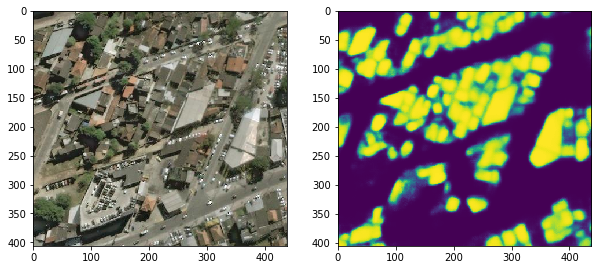

In [15]:
z,x,y = 19,319454,270706
url= 'https://tiles.openaerialmap.org/5d050c3673de290005853a91/0/5d050c3673de290005853a92/18/203079/117283.png'
url=base_path + "datasets/RIO/3band/3band_AOI_1_RIO_img5378.tif"

test_tile = skimage.io.imread(url)
result = get_pred(inference_learner, test_tile)
  
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(test_tile)
ax2.imshow(result)
plt.show()

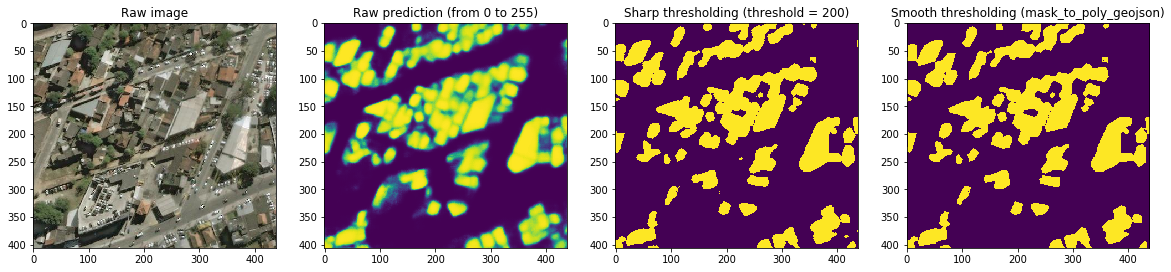

In [16]:
# threshold and polygonize with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_mask_to_vector.html

threshold = 200
poly = sol.vector.mask.mask_to_poly_geojson(result, channel_scaling=[1], bg_threshold=threshold, simplify=True, tolerance=2)
mask_th = sol.vector.mask.instance_mask(poly, geom_col='geometry', shape=shape_image, out_type='int', burn_value=1, nodata_value=0)
  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,5))
ax1.set_title('Raw image')
ax1.imshow(test_tile)

ax2.set_title('Raw prediction (from 0 to 255)')
ax2.imshow(result)

ax3.set_title(f'Sharp thresholding (threshold = {threshold})')
ax3.imshow((result > threshold).astype(float)) # manual thresholding

ax4.set_title(f'Smooth thresholding (mask_to_poly_geojson)')
ax4.imshow(mask_th.sum(axis=2)) # preprocess with algorithm simplify 
plt.show()

In [0]:
from shapely.geometry import Polygon, shape, Point
import gdal
import tqdm

# 200mx200m tiles, where (406, 438)
def Pixel2World(geoMatrix, i, j):
    ulX = geoMatrix[0]
    ulY = geoMatrix[3]
    xDist = geoMatrix[1]
    yDist = geoMatrix[5]
    rtnX = geoMatrix[2]
    rtnY = geoMatrix[4]
    return(1.0 * i * xDist  + ulX, -1.0 * j * xDist + ulY)

def yuanDistanceTransform(url, gjson):
  ds8 = gdal.Open(url)
  geoTrans = ds8.GetGeoTransform()
  dist = np.zeros((ds8.RasterYSize, ds8.RasterXSize))
  #print(dist.shape)
  polygons = [shape(geom) for geom in gjson['geometry']]

  for i in tqdm.tqdm(range(ds8.RasterXSize)):
    for j in range(ds8.RasterYSize):
      #point = Point(Pixel2World(geoTrans, i , j))
      point = Point((i, j))
      #print("Point: ")
      #print(point)
      pd = -100000.0
      for polygon in polygons:
        #print("Polygon: ")
        #print(polygon)
        if polygon.contains(point):
          newpd = 0.0
        else:
          newpd = -point.distance(polygon.boundary)
        if newpd > pd:
            pd = newpd
        dist[j, i] = pd # polygons and pixel coordinates are opposite to that shown in previous plots
        if(pd == 0):
          break
  return dist

In [53]:
dist_matrix = yuanDistanceTransform(base_path + "datasets/RIO/3band/3band_AOI_1_RIO_img5378.tif", poly)











  0%|          | 0/439 [00:00<?, ?it/s]









  0%|          | 1/439 [00:00<02:43,  2.68it/s]









  0%|          | 2/439 [00:00<02:42,  2.69it/s]









  1%|          | 3/439 [00:01<02:38,  2.75it/s]









  1%|          | 4/439 [00:01<02:35,  2.80it/s]









  1%|          | 5/439 [00:01<02:32,  2.85it/s]









  1%|▏         | 6/439 [00:02<02:32,  2.85it/s]









  2%|▏         | 7/439 [00:02<02:30,  2.87it/s]









  2%|▏         | 8/439 [00:02<02:28,  2.90it/s]









  2%|▏         | 9/439 [00:03<02:27,  2.92it/s]









  2%|▏         | 10/439 [00:03<02:27,  2.91it/s]









  3%|▎         | 11/439 [00:03<02:26,  2.92it/s]









  3%|▎         | 12/439 [00:04<02:25,  2.93it/s]









  3%|▎         | 13/439 [00:04<02:26,  2.90it/s]









  3%|▎         | 14/439 [00:04<02:27,  2.88it/s]









  3%|▎         | 15/439 [00:05<02:27,  2.88it/s]









  4%|▎         | 16/439 [00:05<02:28,  2.85it/s]









  4%|▍         | 17/43

In [0]:
pixels_per_meter = test_tile.shape[0]*test_tile.shape[1] / (200 * 200) # how many pixels per meter
maximum_distance_m = 200 # maximum distance in meters
maximum_distance_p = maximum_distance_m * pixels_per_meter

def rescale_200m_bins(x, n_min=0.0, n_max=200.0):
  x_m = -1 * x / float(pixels_per_meter) # distance in pixels -> move to meters
  return np.round(x_m) # maximum distance is 200m, so it will range from 0 to 200.

def rescale(x, n_min=0.0, n_max=200.0):
  x_m = x / float(pixels_per_meter) # distance in pixels -> move to meters
  o_min = np.min(x_m)
  o_max = np.max(x_m)
  return n_min + ((x - o_min) * (n_max - n_min)) / float(o_max - o_min)

In [0]:
dist_matrix_rescaled = rescale_200m_bins(dist_matrix)

In [56]:
dist_matrix

array([[-38.327536, -38.078866, -37.854986, -37.656341, ..., -71.028163, -72.027772, -73.027392, -74.027022],
       [-37.363083, -37.107951, -36.878178, -36.674242, ..., -71.007042, -72.006944, -73.006849, -74.006756],
       [-36.400549, -36.138622, -35.902646, -35.693137, ..., -71.      , -72.      , -73.      , -74.      ],
       [-35.44009 , -35.171011, -34.928498, -34.71311 , ..., -71.      , -72.      , -73.      , -74.      ],
       ...,
       [ -0.      ,   0.      ,   0.      ,   0.      , ...,  -2.      ,  -3.      ,  -4.      ,  -5.      ],
       [ -0.      ,   0.      ,   0.      ,   0.      , ...,  -2.      ,  -3.      ,  -4.      ,  -5.      ],
       [ -0.      ,   0.      ,   0.      ,   0.      , ...,  -2.      ,  -3.      ,  -4.      ,  -5.      ],
       [ -0.      ,   0.      ,   0.      ,   0.      , ...,  -2.      ,  -3.      ,  -4.      ,  -5.      ]])

In [59]:
dist_matrix_rescaled

array([[ 9.,  9.,  8.,  8., ..., 16., 16., 16., 17.],
       [ 8.,  8.,  8.,  8., ..., 16., 16., 16., 17.],
       [ 8.,  8.,  8.,  8., ..., 16., 16., 16., 17.],
       [ 8.,  8.,  8.,  8., ..., 16., 16., 16., 17.],
       ...,
       [ 0., -0., -0., -0., ...,  0.,  1.,  1.,  1.],
       [ 0., -0., -0., -0., ...,  0.,  1.,  1.,  1.],
       [ 0., -0., -0., -0., ...,  0.,  1.,  1.,  1.],
       [ 0., -0., -0., -0., ...,  0.,  1.,  1.,  1.]])

In [0]:
with open(base_path + 'output/output_signed_m_3band_AOI_1_RIO_img5378.pkl','wb') as f:
  pickle.dump(dist_matrix_rescaled, f)
with open(base_path + 'output/output_signed_3band_AOI_1_RIO_img5378.pkl','wb') as f:
  pickle.dump(dist_matrix, f)

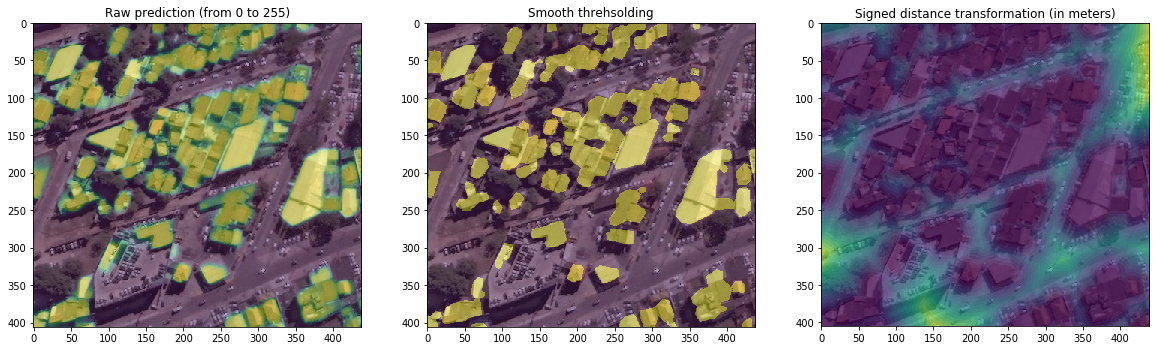

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,10))
#ax1.imshow(test_tile)
ax1.set_title('Raw prediction (from 0 to 255)')
ax1.imshow(test_tile)
ax1.imshow(result, alpha = 0.4)
ax2.set_title('Smooth threhsolding')
ax2.imshow(test_tile)
ax2.imshow(mask_th.sum(axis=2), alpha=0.4)
ax3.set_title('Signed distance transformation (in meters)')
ax3.imshow(test_tile)
ax3.imshow(dist_matrix_rescaled, alpha = 0.7)
plt.show()

In [90]:
!ls "/content/drive/My Drive/output/"

output_signed_3band_AOI_1_RIO_img5378.pkl
output_signed_m_3band_AOI_1_RIO_img5378.pkl


# Coming Up

If you liked this tutorial, look forward to next ones which will potentially cover topics like:
- classifying building completeness (foundation, incomplete, complete)
- inference on multiple tiles and much larger images
- working with messy, sparse, imperfect training data
- model deployment and inference at scale
- examining data/model biases, considerations of fairness, accountability, transparency, and ethics

Curious about more geospatial deep learning topics? Did I miss something? Share your questions and thoughts in the [Medium post](https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321?source=friends_link&sk=57b82002ac47724ecf9a2aaa98de994b) so I can add them into this and next tutorials. 

Good luck and happy deep learning!


# Acknowledgments and Special Thanks to

- [World Bank GFDRR](https://www.gfdrr.org/en)'s Open Data for Resilience
Initiative ([OpenDRI](https://opendri.org/)) for consultation projects which have inspired & informed.
- [Zanzibar Mapping Initiative](http://www.zanzibarmapping.com/), [OpenAerialMap](https://openaerialmap.org/), State University of Zanzibar ([SUZA](https://www.suza.ac.tz/)), Govt of Zanzibar's Commission for Lands, & [WeRobotics](https://werobotics.org/) for the [2018 Open AI Tanzania Building Footprint Segmentation Challenge](https://competitions.codalab.org/competitions/20100).
- [Fast.ai team](https://www.fast.ai/about/), [contributors](https://github.com/fastai/fastai/graphs/contributors), & [community](https://forums.fast.ai/) for both "making neural nets uncool again" and pushing its cutting edge (very cool).
- [SpaceNet](https://spacenet.ai/) & [Cosmiq Works](http://www.cosmiqworks.org/) for the open challenges, datasets, knowledge-sharing, [Solaris geoML toolkit](https://github.com/CosmiQ/solaris), & more that advance geospatial machine learning.
- Contributors to [COG](https://www.cogeo.org/), [STAC](https://stacspec.org/), and more initiatives advancing the [cloud native geospatial](https://medium.com/planet-stories/tagged/cloud-native-geospatial) ecosystem.
- [Free & open source](https://en.wikipedia.org/wiki/Free_and_open-source_software) creators & collaborators everywhere for the invaluable public goods you provide.

# Notebook Changelog

## v1 (2019-07-25):
-------
New: 1st public release

Changed: n/a

Fixed: n/a